In [1]:
import pandas as pd 
import numpy as np

from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, FunctionTransformer, StandardScaler, LabelBinarizer, FunctionTransformer, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import plot_roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from itertools import  product
from scipy.linalg import LinAlgError

import scipy
from scipy.stats import f_oneway, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("ticks")

import torch
from torch import nn
from pyro.nn import PyroModule
from pyro.nn import PyroSample

from pyro.infer.autoguide import AutoDiagonalNormal, AutoLowRankMultivariateNormal, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO

import pyro
import pyro.distributions as dist

data_path = "./CART_tables_25Nov2022/"
# "./CART_ML_Data_20Dec2021/CART_Response_binarized_X_train.xlsx"
%matplotlib inline

# ML utils

## sklearn compatible transformers for pipelining

In [2]:
class ColumnsIdentifier(BaseEstimator, TransformerMixin):
    def __init__(self, columns_lst):
        self.columns_lst = columns_lst
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        Xt = X.copy()
        Xt = Xt.loc[:,self.columns_lst]
        return Xt
    
class RAFilter(BaseEstimator, TransformerMixin):
    def __init__(self, capval = 5e-2):
        self._f_list = []
        self.capval = capval
        pass

    def fit(self, X,y=None, modemap = []):
        X_t = X.copy()
        X_t = 100 * X_t.div(X_t.sum(axis=1), axis=0)
        self._f_list = [i for i in range(X_t.shape[1]) if X_t.iloc[:,i].max() > self.capval ]
        return self
    
    def transform(self, X, y = None):
        X_t = X.iloc[:,self._f_list].copy()
        X_t[X_t < self.capval] = self.capval
        X_t = 100 * X_t / X_t.values.sum(axis=1,keepdims = True)
        return X_t


    def fit_transform(self, X, y = None, modemap = []):
        self = self.fit(X, y, modemap)
        Xt = self.transform(X, y)
        return Xt
    
class PLSRegressionWrapper(PLSRegression):

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X)

## Probabilistic programing related utils

* ```BayesianLogisticRegression```: a `PyroModule` for making predictions with quatifiable uncertainty
* `trainingloop`: function for fitting optimal distribution over ```BayesianLogisticRegression``` object given a guide function, trainig data and an optimizer
* `get_probs`: function for making prediction on input `X` based on random sample of a trained guide function 
* `plot_mean_auroc`: helper function for plotting mean roc curve

In [203]:
class BayesianLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features
                 , linear_weight_loc = 0.0
                 , linear_weight_scale = 10.0
                 , bias_loc = 0.0
                 , bias_scale = 10.):
        super().__init__()
        self.input_dim = in_features
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(linear_weight_loc, linear_weight_scale).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(bias_loc, bias_scale).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1)
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits = logits), obs=y)
        return logits
    
class BayesianLogisticRegressionLaplace(PyroModule):
    def __init__(self, in_features, out_features
                 , linear_weight_loc = 0.0
                 , linear_weight_scale = 10.0
                 , bias_loc = 0.0
                 , bias_scale = 10.):
        super().__init__()
        self.input_dim = in_features
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Laplace(linear_weight_loc, linear_weight_scale).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Laplace(bias_loc, bias_scale).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        logits = self.linear(x).squeeze(-1)
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits = logits), obs=y)
        return logits
    

    
def get_probs(guide, X):
    with torch.no_grad():
        gs = guide()
        w,b = gs['linear.weight'], gs['linear.bias']
        probs = (nn.Sigmoid()(w @ X.T + b)).squeeze()
    return probs.detach().numpy()


def trainingloop(data_x, data_y, model, guide, optimizer, num_iterations = 10001, report_size = 500):
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    
    minloss = np.inf
    lossmean_arr = np.zeros((report_size,))
    loss_l = []
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(data_x, data_y)
        minloss = min(minloss,loss/ len(data_x))
        loss_l.append(loss/ len(data_x))
        lossmean_arr[j % report_size] = loss/ len(data_x)
        
        
        if j % report_size == 0:
            if j > 0:
                print("[iteration %05d] loss: %.4f" % (j + 1, loss / len(data_x))
                      , "loss min: %.4f" %(minloss)
                      , "loss mean: %.4f"%(lossmean_arr.mean())
                      , "loss sd: %.4f"%(lossmean_arr.std()))
            else:
                print("[iteration %05d] loss: %.4f" % (j + 1, loss / len(data_x)), "minloss: %.4f" %(minloss))


def plot_mean_auroc(tprs, mean_fpr, aucs, ax, meancolor = 'b' ):
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=meancolor,
        label="Mean ROC\n"+r"(AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="ROC",
    )
    ax.legend(loc="lower right", fontsize = 6)
    
    


## CR180

### No HR

In [204]:
# reading and subsetting patients list
stool_table = pd.read_excel(f"{data_path}/CART_table_stool.xlsx"
                               , engine='openpyxl')\
                                .query("sampleDay_sample < 1")\
                                .query("sampleDay_sample >= -21")\
                                .query("Basal_no_HighRisk_sample == True")

subs = # Here is given a set indicating patients to be excluded in accordance with the exclusion criteria  # 

_sid_subset = stool_table['subjectID'].unique()
_sid_subset = [s for s in _sid_subset if s not in subs]


patients_table = pd.read_excel(f"{data_path}/CART_table_patients.xlsx"
                               , engine='openpyxl')\
                                .query(f"subjectID in @_sid_subset")


response_table = pd.read_excel(f"{data_path}/CART_table_response.xlsx"
                               , engine='openpyxl')\
                                .query('Day == 180')\
                                .query('subjectID in @ _sid_subset')\
                                .dropna(subset = ['Response'])

patients_table = patients_table.loc[patients_table['subjectID'].isin(response_table['subjectID'])]
response_table = response_table.loc[response_table['subjectID'].isin(patients_table['subjectID'])]
stool_table = stool_table.loc[stool_table['subjectID'].isin(patients_table['subjectID'])]





# read stool feature tables
taxa_table = stool_table.loc[:,['subjectID','stool_sample_id']].merge(pd.read_excel(f"{data_path}/CART_table_taxa.xlsx", engine='openpyxl'), how = 'left')\
                    .groupby(['subjectID']).apply(lambda x:x.iloc[:,1:].mean())


stool_table = stool_table.loc[stool_table['subjectID'].isin(taxa_table.index)]
patients_table = patients_table.loc[patients_table['subjectID'].isin(taxa_table.index)]

_sid_subset = stool_table['subjectID'].unique()

# train - test split
train_patients = patients_table.query('Country == "Germany"')['subjectID'].unique().tolist()
test_patients = patients_table.query('Country == "US"')['subjectID'].unique().tolist()

# X
patients_x = patients_table.set_index(['subjectID']).loc[:,['Gender','Age']]
patients_x['gender_m'] = 1*(patients_x['Gender'] == 'm')
patients_x['gender_f'] = 1*(patients_x['Gender'] == 'f')
patients_x.drop('Gender', axis=1,inplace = True)

taxa_cols = taxa_table.columns.tolist()
clinical_cols = patients_x.columns.tolist()

X_all = pd.concat([taxa_table, patients_x], axis=1)
X_atrain, X_atest = X_all.loc[train_patients].copy(), X_all.loc[test_patients].copy()



# y


cr_y = 1 * (response_table.set_index('subjectID')['Response'] == 'CR').loc[X_all.index]
cr_y_train, cr_y_test = cr_y.loc[train_patients].copy(), cr_y.loc[test_patients].copy()


# read selected taxa
taxa_columns_ser = pd.read_csv("./deterministic_results/CR180_noHighRiskABX_elasticnet_train_coefficients.csv", index_col=0,squeeze=True)
selected_columns_ser = (taxa_columns_ser[taxa_columns_ser.abs()>0]**2).nlargest( 30 )
selected_taxa = selected_columns_ser.index.tolist()


# fit transformer with predefined params
feature_extractors2 = []
prep_taxa = Pipeline([("fset", ColumnsIdentifier(taxa_cols)),
                      ('raf', RAFilter(capval=0.001)),
                      ('fset2', ColumnsIdentifier(selected_taxa)),
                      ('log',FunctionTransformer(lambda x: np.log10(1 + x))),
                      ('SS', StandardScaler(with_std=False)),
                     ])

feature_extractors2.append(('taxa',prep_taxa))
union2 = FeatureUnion(feature_extractors2)

# clf_pipe2.fit()
X_train_trans =  union2.fit_transform(X_atrain, cr_y_train)
X_test_trans = union2.transform(X_atest)


print("CR180 no HRABX")
print(f"train: {X_atrain.shape}")
print(f"test: {X_atest.shape}")

CR180 no HRABX
train: (43, 552)
test: (36, 552)


/tmp/ipykernel_259209/3583684523.py:36: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  .groupby(['subjectID']).apply(lambda x:x.iloc[:,1:].mean())


#### Train CR noHR 

In [208]:
pyro.clear_param_store()

model = BayesianLogisticRegression(len(selected_taxa), 1)
guide = AutoLowRankMultivariateNormal(model, rank = int(np.sqrt(model.input_dim)))
adam = pyro.optim.SGD({"lr": 0.01})


pyro_train_x = torch.Tensor(X_train_trans)
pyro_train_y = torch.Tensor(cr_y_train)


trainingloop(pyro_train_x, pyro_train_y,model,guide, adam, num_iterations=10001, report_size=500)


[iteration 00001] loss: 5.2138 minloss: 5.2138
[iteration 00501] loss: 1.6344 loss min: 1.2105 loss mean: 2.5893 loss sd: 1.0752
[iteration 01001] loss: 1.0658 loss min: 0.8357 loss mean: 1.2411 loss sd: 0.1365
[iteration 01501] loss: 1.0755 loss min: 0.7542 loss mean: 1.0316 loss sd: 0.0951
[iteration 02001] loss: 0.9071 loss min: 0.6868 loss mean: 0.9423 loss sd: 0.0834
[iteration 02501] loss: 0.7639 loss min: 0.6510 loss mean: 0.8865 loss sd: 0.0909
[iteration 03001] loss: 0.8723 loss min: 0.6510 loss mean: 0.8520 loss sd: 0.0808
[iteration 03501] loss: 0.8075 loss min: 0.5993 loss mean: 0.8278 loss sd: 0.0916
[iteration 04001] loss: 0.9407 loss min: 0.5405 loss mean: 0.8076 loss sd: 0.0844
[iteration 04501] loss: 0.7734 loss min: 0.5405 loss mean: 0.8033 loss sd: 0.0849
[iteration 05001] loss: 0.8007 loss min: 0.5215 loss mean: 0.7886 loss sd: 0.0860
[iteration 05501] loss: 0.8108 loss min: 0.5215 loss mean: 0.7754 loss sd: 0.0824
[iteration 06001] loss: 0.7338 loss min: 0.5215 los

#### ROC curves

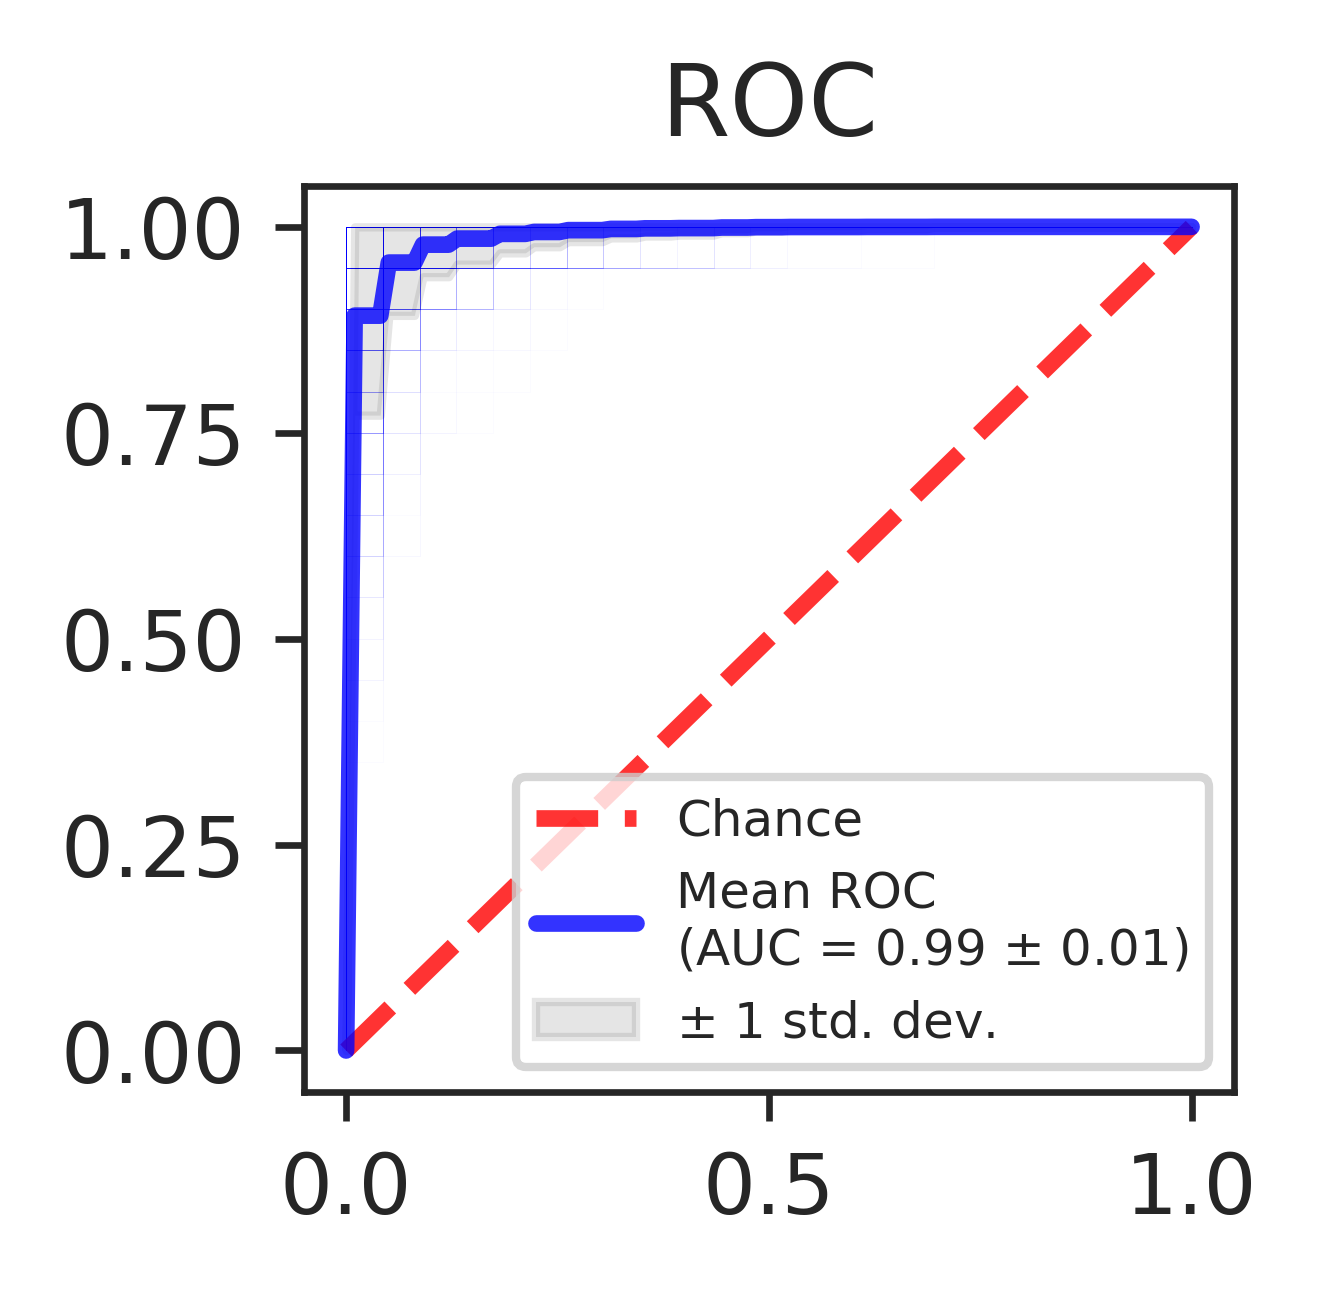

In [209]:
fig, ax = plt.subplots(figsize = [2,2], dpi = 600)


    
train_tprs_crnohr = []
train_aucs_crnohr = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(500):
    probs = get_probs(guide, X_train_trans)



    fpr, tpr, _ = roc_curve(cr_y_train, probs)
    ax.plot(fpr,tpr, c = 'b', lw = .1, alpha = .02)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    train_tprs_crnohr.append(interp_tpr)
    train_aucs_crnohr.append(auc(fpr,tpr))


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plot_mean_auroc(train_tprs_crnohr, mean_fpr, train_aucs_crnohr, ax )
plt.savefig("./probabilistic_results/rocdf_train_crnohr.pdf", bbox_inches='tight')

plt.show()


rocdf_train_crnohr = pd.DataFrame(train_tprs_crnohr, columns=mean_fpr).T\
                .assign(mean = lambda df: df.mean(axis=1), std = lambda df: df.std(axis=1))\
                .assign(lower = lambda df: np.maximum(df['mean'] - df['std'],0)
                        , upper = lambda df: np.minimum(df['mean'] + df['std'],1))
rocdf_train_crnohr.to_csv("./probabilistic_results/rocdf_train_crnohr.csv")

rocsummaries_train_crnohr = pd.DataFrame(train_aucs_crnohr, columns=['sample'])['sample'].agg(['mean','std']).round(2)
rocsummaries_train_crnohr.to_csv("./probabilistic_results/rocsummaries_train_crnohr.csv")

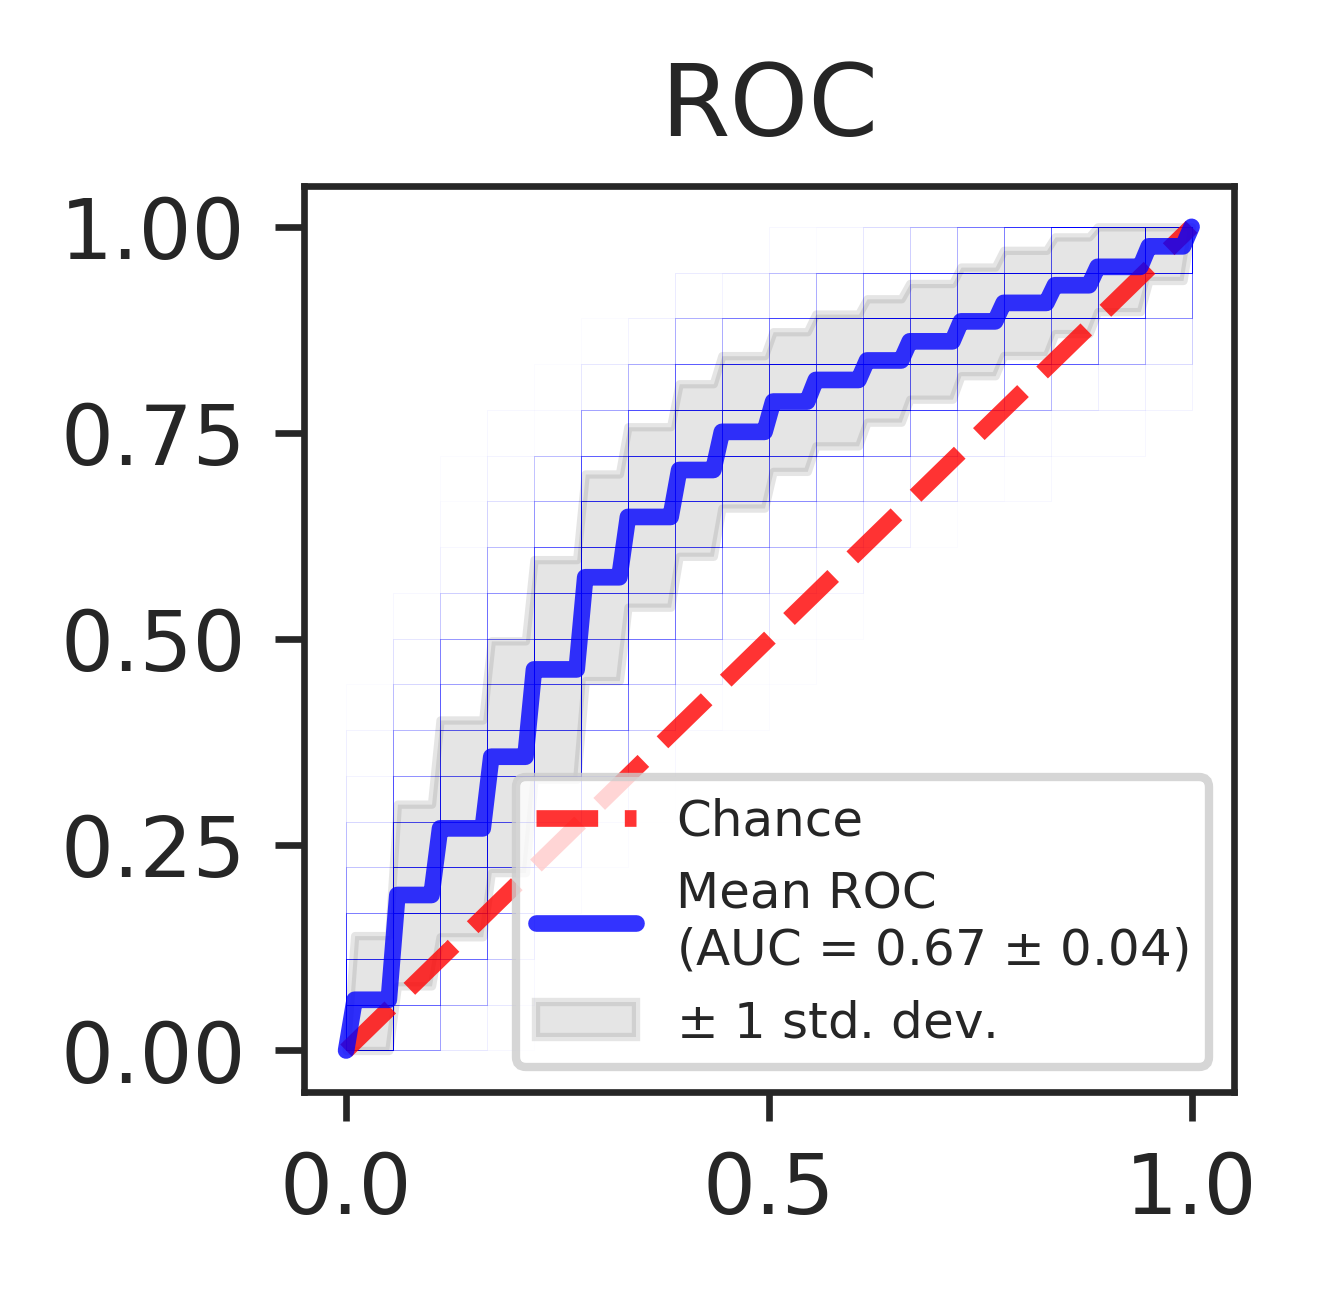

In [210]:
# pred_summary['_RETURN']


fig, ax = plt.subplots(figsize = [2,2], dpi = 600)


    
test_tprs_crnohr = []
test_aucs_crnohr = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(500):
    probs = get_probs(guide, X_test_trans)



    fpr, tpr, _ = roc_curve(cr_y_test, probs)
    ax.plot(fpr,tpr, c = 'b', lw = .1, alpha = .02)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    test_tprs_crnohr.append(interp_tpr)
    test_aucs_crnohr.append(auc(fpr,tpr))


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plot_mean_auroc(test_tprs_crnohr, mean_fpr, test_aucs_crnohr, ax )
plt.savefig("./probabilistic_results/rocdf_test_crnohr.pdf", bbox_inches='tight')
plt.show()


rocdf_test_crnohr = pd.DataFrame(test_tprs_crnohr, columns=mean_fpr).T\
                .assign(mean = lambda df: df.mean(axis=1), std = lambda df: df.std(axis=1))\
                .assign(lower = lambda df: np.maximum(df['mean'] - df['std'],0)
                        , upper = lambda df: np.minimum(df['mean'] + df['std'],1))
rocdf_test_crnohr.to_csv("./probabilistic_results/rocdf_test_crnohr.csv")

rocsummaries_test_crnohr = pd.DataFrame(test_aucs_crnohr, columns=['sample'])['sample'].agg(['mean','std']).round(2)
rocsummaries_test_crnohr.to_csv("./probabilistic_results/rocsummaries_test_crnohr.csv")

#### PCA

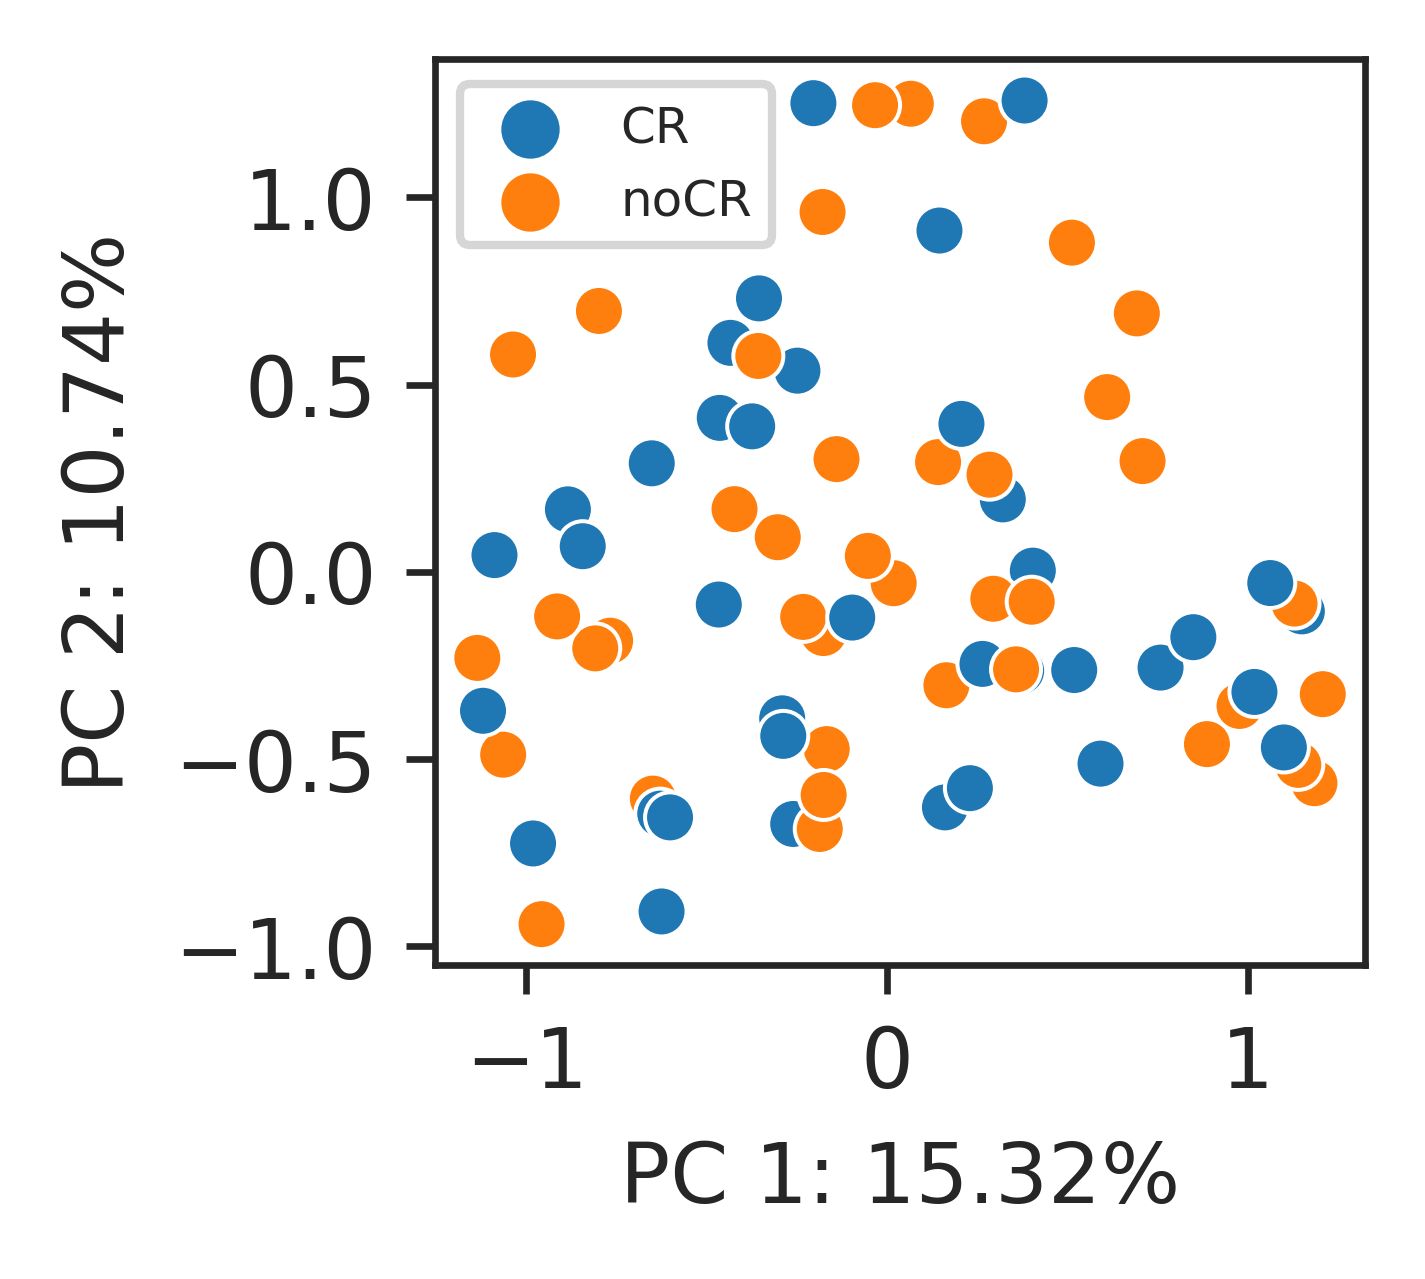

In [217]:


X_pca_crnohr =  union2.transform(X_all) 



pca_crnohr = PCA()
pca_crnohr_df = pd.DataFrame(pca_crnohr.fit_transform(X_pca_crnohr), index = X_all.index)
pca_crnohr_df_columns = [f"PC {c+1}: {np.round(pca_crnohr.explained_variance_ratio_[c]*100,2)}%" for c in pca_crnohr_df.columns]
pca_crnohr_df.columns = pca_crnohr_df_columns
pca_crnohr_df_response = pca_crnohr_df.join(cr_y.map({0:'noCR', 1:'CR'}))


fig, ax = plt.subplots(figsize = [2,2], dpi = 600)
sns.scatterplot(data = pca_crnohr_df_response, x = pca_crnohr_df_columns[0],y=pca_crnohr_df_columns[1], hue='Response')
plt.legend(fontsize = 6)
plt.savefig("./deterministic_results/pca_crnohr_df_response.pdf", bbox_inches='tight')


pca_crnohr_df_response.to_csv("./deterministic_results/pca_crnohr_df_response.csv")

### with HR abx

In [218]:
stool_table_habx = pd.read_excel(f"{data_path}/CART_table_stool.xlsx"
                               , engine='openpyxl')\
                                .query("sampleDay_sample < 1")\
                                .query("sampleDay_sample >= -21")
#                                 .query("Basal_no_HighRisk_sample == True")

subs = ['ID210413', 'LY2820200435', 'LY4120210253', 'LY4120210767', 'TS210817']
subs += ['LY4120190816', 'TS210817', 'moff_11', 'moff_21', 'mda.car.008', 'mda.car.027']

_sid_subset_habx = stool_table_habx['subjectID'].unique()
_sid_subset_habx = [s for s in _sid_subset_habx if s not in subs]


patients_table_habx = pd.read_excel(f"{data_path}/CART_table_patients.xlsx"
                               , engine='openpyxl')\
                                .query(f"subjectID in @_sid_subset_habx")
                                

response_table_habx = pd.read_excel(f"{data_path}/CART_table_response.xlsx"
                               , engine='openpyxl')\
                                .query('Day == 180')\
                                .query('subjectID in @_sid_subset_habx')\
                                .dropna(subset = ['Response'])

patients_table_habx = patients_table_habx.loc[patients_table_habx['subjectID'].isin(response_table_habx['subjectID'])]
response_table_habx = response_table_habx.loc[response_table_habx['subjectID'].isin(patients_table_habx['subjectID'])]
stool_table_habx = stool_table_habx.loc[stool_table_habx['subjectID'].isin(patients_table_habx['subjectID'])]






taxa_table_habx = stool_table_habx.loc[:,['subjectID','stool_sample_id']].merge(pd.read_excel(f"{data_path}/CART_table_taxa.xlsx", engine='openpyxl'), how = 'left')\
                    .groupby(['subjectID']).apply(lambda x:x.iloc[:,1:].mean())





# train - test split
train_patients_habx = patients_table_habx.query('Country == "Germany"')['subjectID'].unique().tolist()
test_patients_habx = patients_table_habx.query('Country == "US"')['subjectID'].unique().tolist()

patients_x_habx = patients_table_habx.set_index(['subjectID']).loc[:,['Gender','Age']]
patients_x_habx['gender_m'] = 1*(patients_x_habx['Gender'] == 'm')
patients_x_habx['gender_f'] = 1*(patients_x_habx['Gender'] == 'f')
patients_x_habx.drop('Gender', axis=1,inplace = True)



X_all_habx = pd.concat([taxa_table_habx, patients_x_habx], axis=1)
X_atrain_habx, X_atest_habx = X_all_habx.loc[train_patients_habx].copy(), X_all_habx.loc[test_patients_habx].copy()



print("CR180 no HRABX")
print(f"train: {X_atrain_habx.shape}")
print(f"test: {X_atest_habx.shape}")


# y

cr_y_habx = 1 * (response_table_habx.set_index('subjectID')['Response'] == 'CR').loc[X_all_habx.index]
cr_y_train_habx, cr_y_test_habx = cr_y_habx.loc[train_patients_habx].copy(), cr_y_habx.loc[test_patients_habx].copy()


# "CR180_WithHighRiskABX_elasticnet_train_coefficients"

taxa_columns_ser_hr = pd.read_csv("/home/labs/elinav/uria/car-t/ML_modeling/CR180_WithHighRiskABX_elasticnet_train_coefficients.csv", index_col=0,squeeze=True)
selected_columns_ser_hr = (taxa_columns_ser_hr[taxa_columns_ser_hr.abs()>0]**2).nlargest( 30 )
selected_taxa_hr = selected_columns_ser_hr.index.tolist()
n_features_in_hr = len(selected_taxa_hr)

feature_extractors_hr = []
prep_taxa_hr = Pipeline([("fset", ColumnsIdentifier(taxa_cols)),
                      ('raf', RAFilter(capval=.001)),
                      ('fset2', ColumnsIdentifier(selected_taxa_hr)),
                      ('log',FunctionTransformer(lambda x: np.log10(1 + x))),
                      ('SS', StandardScaler(with_std=False)),
                     ])

feature_extractors_hr.append(('taxa',prep_taxa_hr))
union_hr = FeatureUnion(feature_extractors_hr)


X_train_trans_hr =  union_hr.fit_transform(X_atrain_habx, cr_y_train_habx)
X_test_trans_hr = union_hr.transform(X_atest_habx)

/tmp/ipykernel_259209/1053864325.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  .groupby(['subjectID']).apply(lambda x:x.iloc[:,1:].mean())


CR180 no HRABX
train: (50, 552)
test: (45, 552)


#### Train CR with HRABX

In [219]:
pyro.clear_param_store()
model_hr = BayesianLogisticRegression(n_features_in_hr, 1)
guide_hr = AutoLowRankMultivariateNormal(model_hr, rank = int(np.sqrt(model_hr.input_dim)))

adam_hr = pyro.optim.SGD({"lr": 0.01})


pyro_train_x_hr = torch.Tensor(X_train_trans_hr)
pyro_train_y_hr = torch.Tensor(cr_y_train_habx)


trainingloop(pyro_train_x_hr, pyro_train_y_hr,model_hr,guide_hr, adam_hr, num_iterations=10001 )

[iteration 00001] loss: 5.7929 minloss: 5.7929
[iteration 00501] loss: 1.4402 loss min: 1.2521 loss mean: 2.4772 loss sd: 1.0031
[iteration 01001] loss: 1.2137 loss min: 1.0702 loss mean: 1.3297 loss sd: 0.1237
[iteration 01501] loss: 1.3295 loss min: 0.9019 loss mean: 1.1441 loss sd: 0.0849
[iteration 02001] loss: 1.0360 loss min: 0.8842 loss mean: 1.0684 loss sd: 0.0734
[iteration 02501] loss: 0.9411 loss min: 0.8428 loss mean: 1.0299 loss sd: 0.0741
[iteration 03001] loss: 0.9997 loss min: 0.7962 loss mean: 1.0054 loss sd: 0.0769
[iteration 03501] loss: 0.8576 loss min: 0.7949 loss mean: 0.9922 loss sd: 0.0746
[iteration 04001] loss: 0.8566 loss min: 0.7121 loss mean: 0.9809 loss sd: 0.0787
[iteration 04501] loss: 0.9113 loss min: 0.7121 loss mean: 0.9691 loss sd: 0.0787
[iteration 05001] loss: 0.9752 loss min: 0.7121 loss mean: 0.9654 loss sd: 0.0782
[iteration 05501] loss: 0.9471 loss min: 0.7121 loss mean: 0.9553 loss sd: 0.0786
[iteration 06001] loss: 0.9404 loss min: 0.7121 los

#### ROC curves

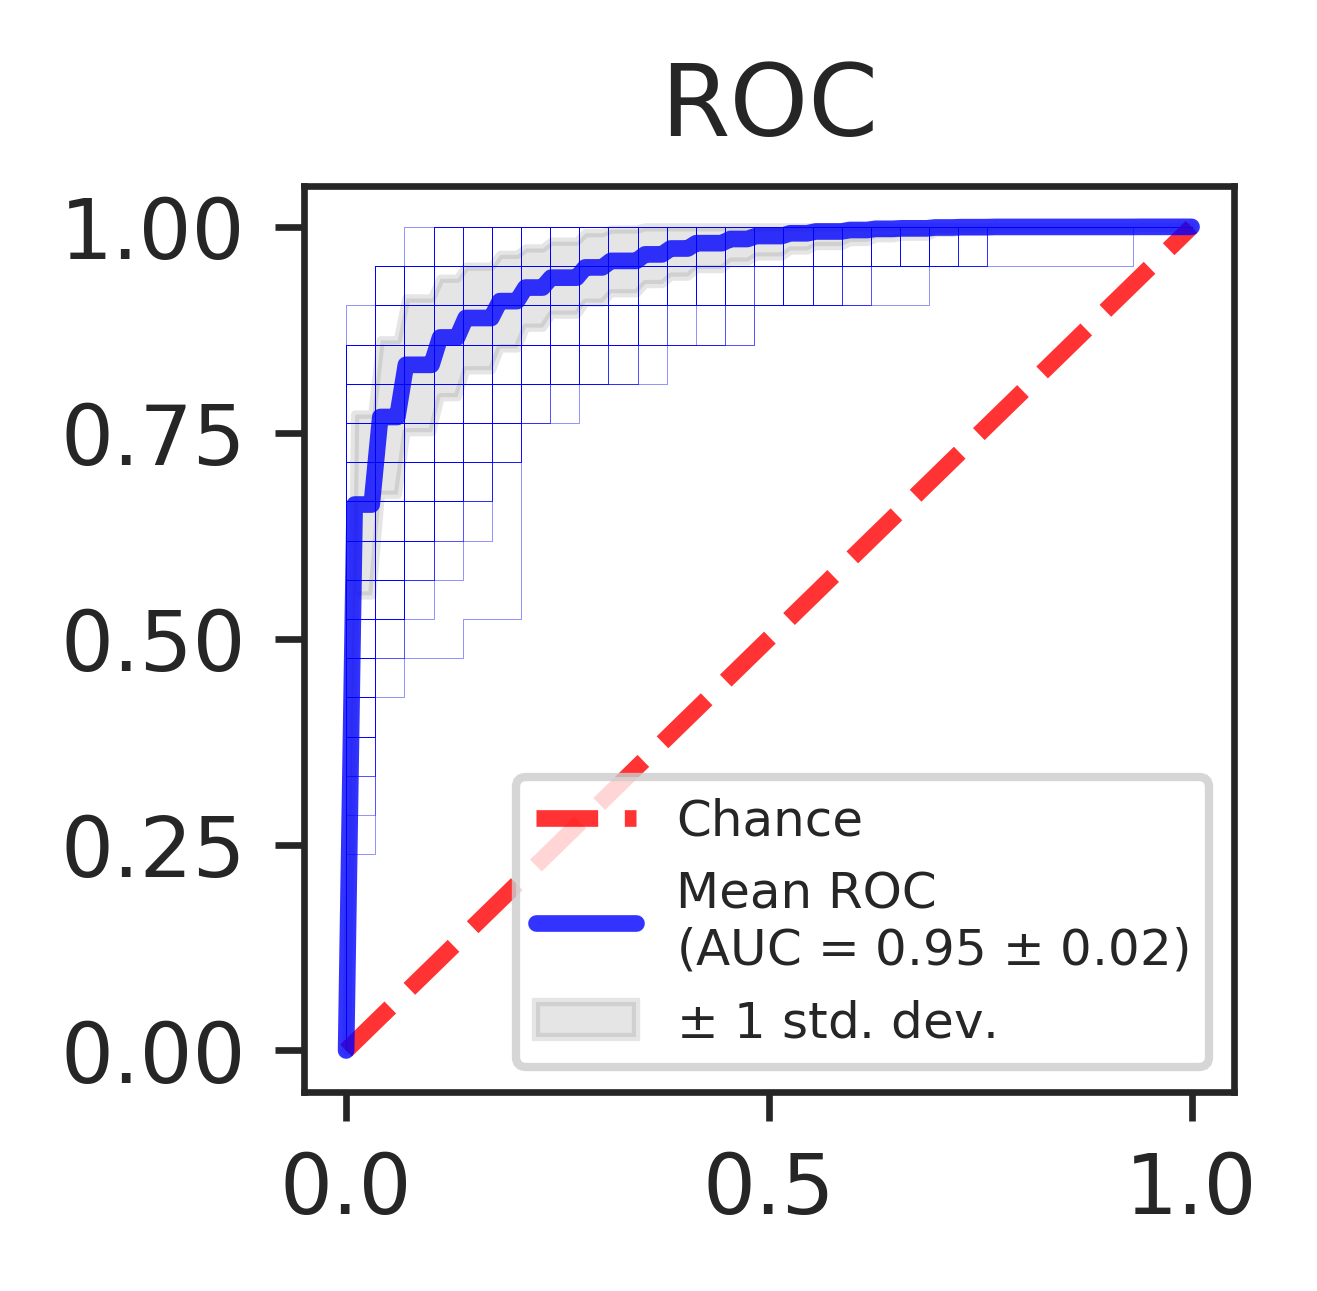

In [220]:
fig, ax = plt.subplots(figsize = [2,2], dpi = 600)

train_tprs_crhr = []
train_aucs_crhr = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(500):
    probs = get_probs(guide_hr, X_train_trans_hr)




    fpr, tpr, _ = roc_curve(cr_y_train_habx, probs)
    ax.plot(fpr,tpr, c = 'b', lw = .1, alpha = .5)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    train_tprs_crhr.append(interp_tpr)
    train_aucs_crhr.append(auc(fpr,tpr))


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plot_mean_auroc(train_tprs_crhr, mean_fpr, train_aucs_crhr, ax )
plt.savefig("./probabilistic_results/rocdf_train_crhr.pdf", bbox_inches='tight')
plt.show()


rocdf_train_crhr = pd.DataFrame(train_tprs_crhr, columns=mean_fpr).T\
                .assign(mean = lambda df: df.mean(axis=1), std = lambda df: df.std(axis=1))\
                .assign(lower = lambda df: np.maximum(df['mean'] - df['std'],0)
                        , upper = lambda df: np.minimum(df['mean'] + df['std'],1))
rocdf_train_crhr.to_csv("./probabilistic_results/rocdf_train_crhr.csv")

rocsummaries_train_crhr = pd.DataFrame(train_aucs_crhr, columns=['sample'])['sample'].agg(['mean','std']).round(2)
rocsummaries_train_crhr.to_csv("./probabilistic_results/rocsummaries_train_crhr.csv")

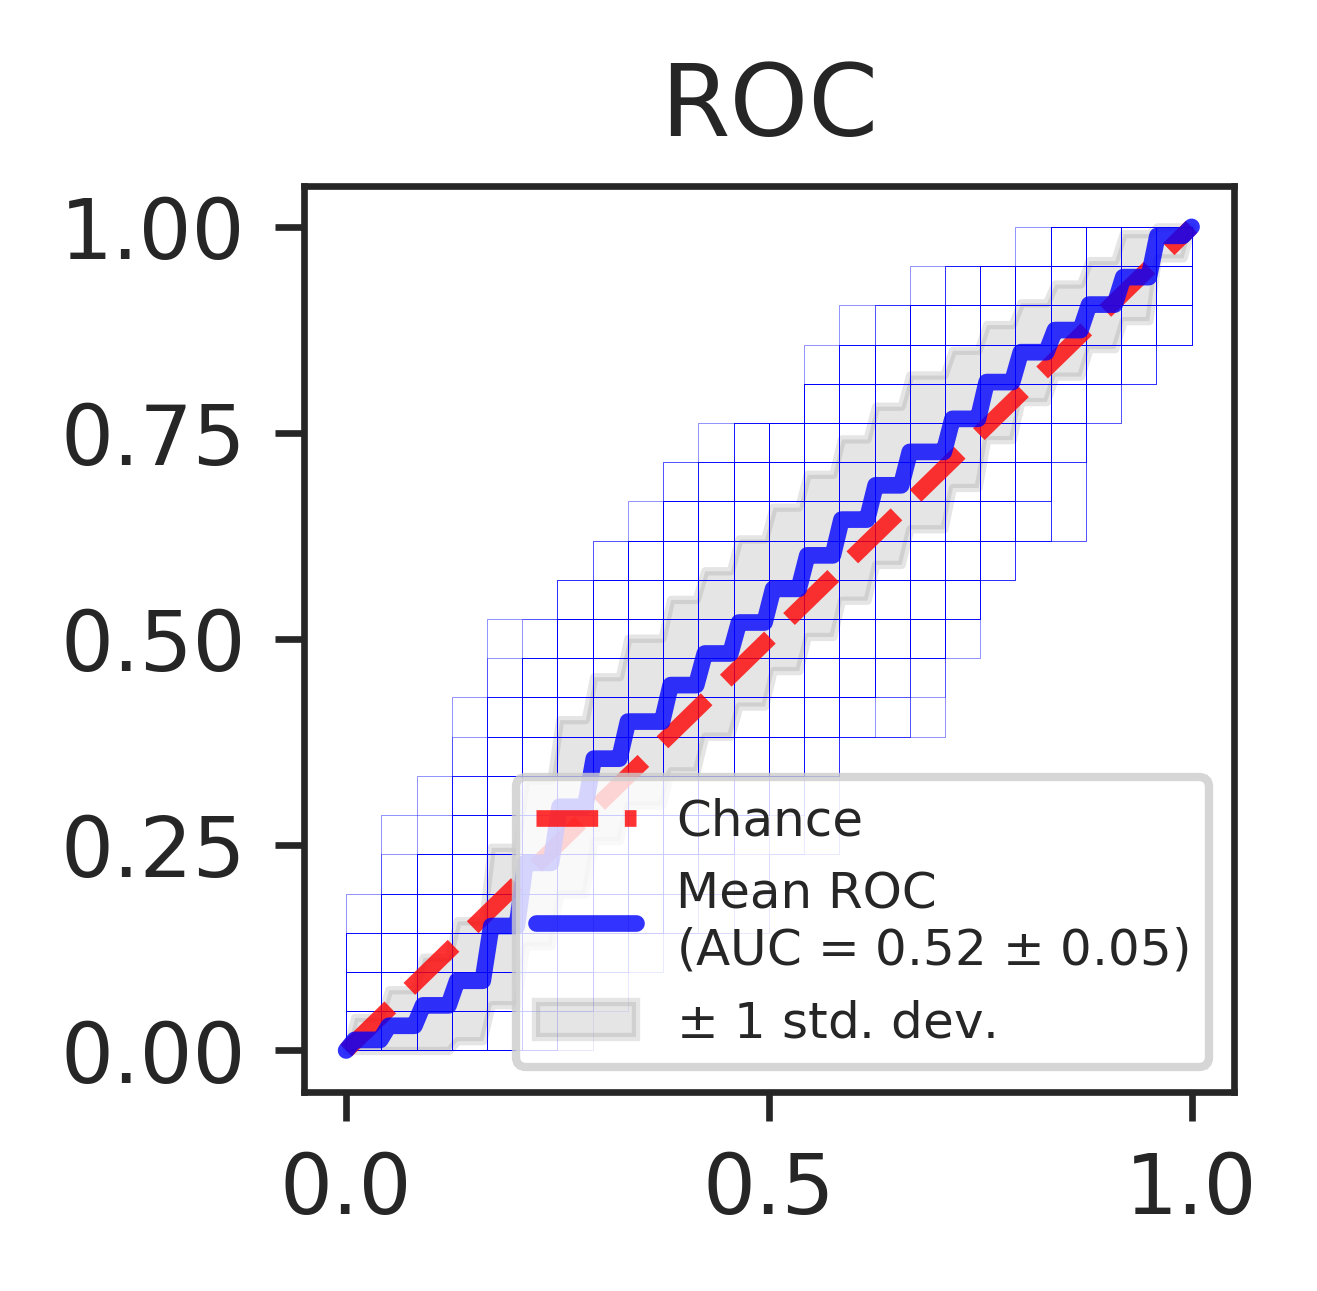

In [221]:
fig, ax = plt.subplots(figsize = [2,2], dpi = 600)

test_tprs_crhr = []
test_aucs_crhr = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(500):
    probs = get_probs(guide_hr, X_test_trans_hr)

    fpr, tpr, _ = roc_curve(cr_y_test_habx, probs)
    ax.plot(fpr,tpr, c = 'b', lw = .1, alpha = .5)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    test_tprs_crhr.append(interp_tpr)
    test_aucs_crhr.append(auc(fpr,tpr))


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plot_mean_auroc(test_tprs_crhr, mean_fpr, test_aucs_crhr, ax )

plt.savefig("./probabilistic_results/rocdf_test_crhr.pdf", bbox_inches='tight')
plt.show()


rocdf_test_crhr = pd.DataFrame(test_tprs_crhr, columns=mean_fpr).T\
                .assign(mean = lambda df: df.mean(axis=1), std = lambda df: df.std(axis=1))\
                .assign(lower = lambda df: np.maximum(df['mean'] - df['std'],0)
                        , upper = lambda df: np.minimum(df['mean'] + df['std'],1))
rocdf_test_crhr.to_csv("./probabilistic_results/rocdf_test_crhr.csv")

rocsummaries_test_crhr = pd.DataFrame(test_aucs_crhr, columns=['sample'])['sample'].agg(['mean','std']).round(2)
rocsummaries_test_crhr.to_csv("./probabilistic_results/rocsummaries_test_crhr.csv")

#### Predictions barplot

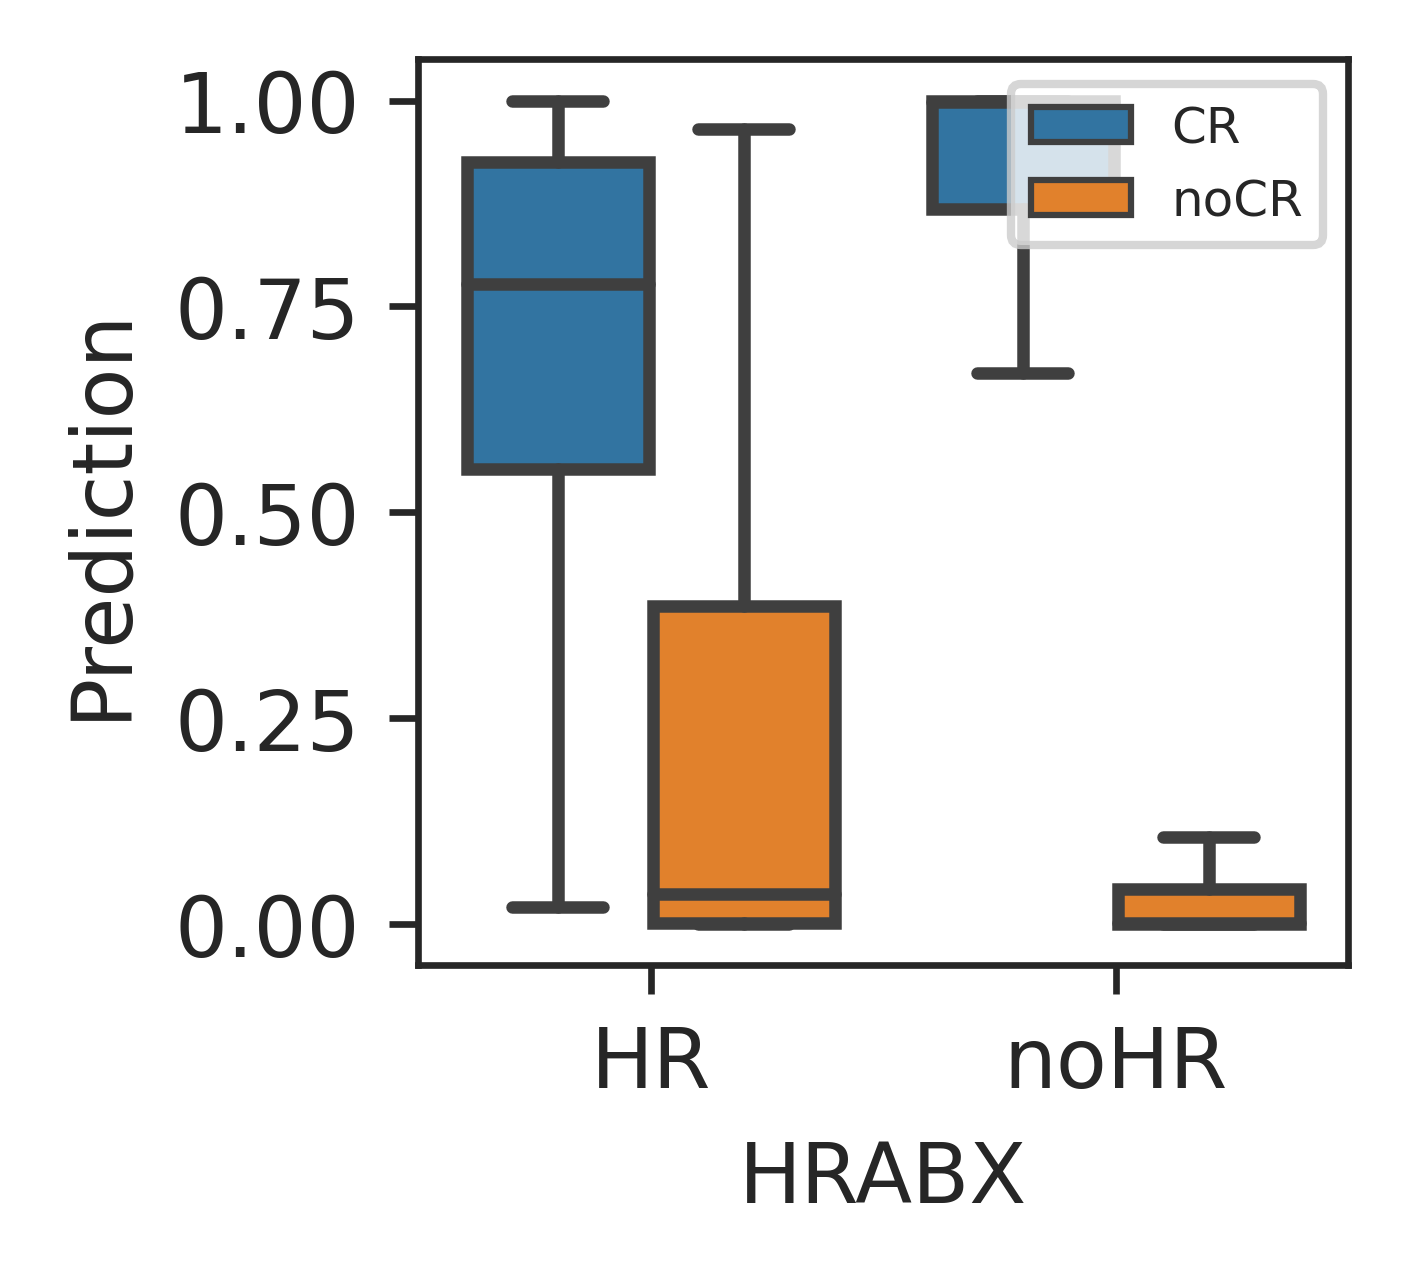

In [222]:
all_nohr_patients = stool_table_habx.query('Basal_no_HighRisk_sample == True')['subjectID'].drop_duplicates()
all_hr_patients = stool_table_habx.query('Basal_no_HighRisk_sample == False')['subjectID'].drop_duplicates()

all_nohr_patients = all_nohr_patients.loc[~all_nohr_patients.isin(subs)]
all_hr_patients = all_hr_patients.loc[~all_hr_patients.isin(subs)]


test_nohr_patients = all_nohr_patients[all_nohr_patients.isin(X_atest_habx.index)].copy()
test_hr_patients = all_hr_patients[all_hr_patients.isin(X_atest_habx.index)].copy()

train_nohr_patients = all_nohr_patients[all_nohr_patients.isin(X_atrain_habx.index)].copy()
train_hr_patients = all_hr_patients[all_hr_patients.isin(X_atrain_habx.index)].copy()




X_test_trans_hr_hr = union_hr.transform(X_atest_habx.loc[test_hr_patients].copy())
Y_test_trans_hr_hr = cr_y_test_habx.loc[test_hr_patients].copy()

X_test_trans_hr_nohr = union_hr.transform(X_atest_habx.loc[test_nohr_patients].copy())
Y_test_trans_hr_nohr = cr_y_test_habx.loc[test_nohr_patients].copy()

X_train_trans_hr_hr = union_hr.transform(X_atrain_habx.loc[train_hr_patients].copy())
Y_train_trans_hr_hr = cr_y_train_habx.loc[train_hr_patients].copy()
X_train_trans_hr_nohr = union_hr.transform(X_atrain_habx.loc[train_nohr_patients].copy())
Y_train_trans_hr_nohr = cr_y_train_habx.loc[train_nohr_patients].copy()

probs_lst = []
for i in range(500):
    probs_lst.append(pd.Series(get_probs(guide_hr, X_train_trans_hr), index = X_atrain_habx.index))
    
probs_table = pd.DataFrame(probs_lst).T\
                .merge(stool_table_habx.loc[:,['subjectID','Basal_no_HighRisk_sample']].drop_duplicates(), left_index = True, right_on='subjectID')\
                .merge(response_table_habx.loc[:,['subjectID','Response']].assign(CR180 = lambda df:df['Response'].apply(lambda x: 'CR' if x == 'CR' else 'noCR')))\
                .pipe(lambda df: pd.melt(df.drop('Response', axis=1), id_vars=['subjectID','Basal_no_HighRisk_sample','CR180'], value_name='prob', var_name='sample' ))\
                .set_index('subjectID').assign(err2 = lambda df: np.sqrt((df['prob'] - cr_y_train_habx)**2).values)\
                .assign(HRABX = lambda df: df["Basal_no_HighRisk_sample"].map({True: "noHR", False:"HR"}))

# probs_table

fig, ax = plt.subplots(figsize = [2,2], dpi = 600)

sns.boxplot(data = probs_table, x='HRABX', y = 'prob', hue = 'CR180', fliersize=0, ax = ax)
plt.ylabel('Prediction')
plt.legend(fontsize = 6, loc = 'upper right')

plt.savefig("./probabilistic_results/cr180_withHRABX_repeated_predictions_barplot.pdf", bbox_inches='tight')
# plt.yscale('log')
plt.show()
probs_table.join(cr_y_habx.rename("label")).to_csv("./probabilistic_results/cr180_withHRABX_repeated_predictions_barplot.csv")


#### PCA

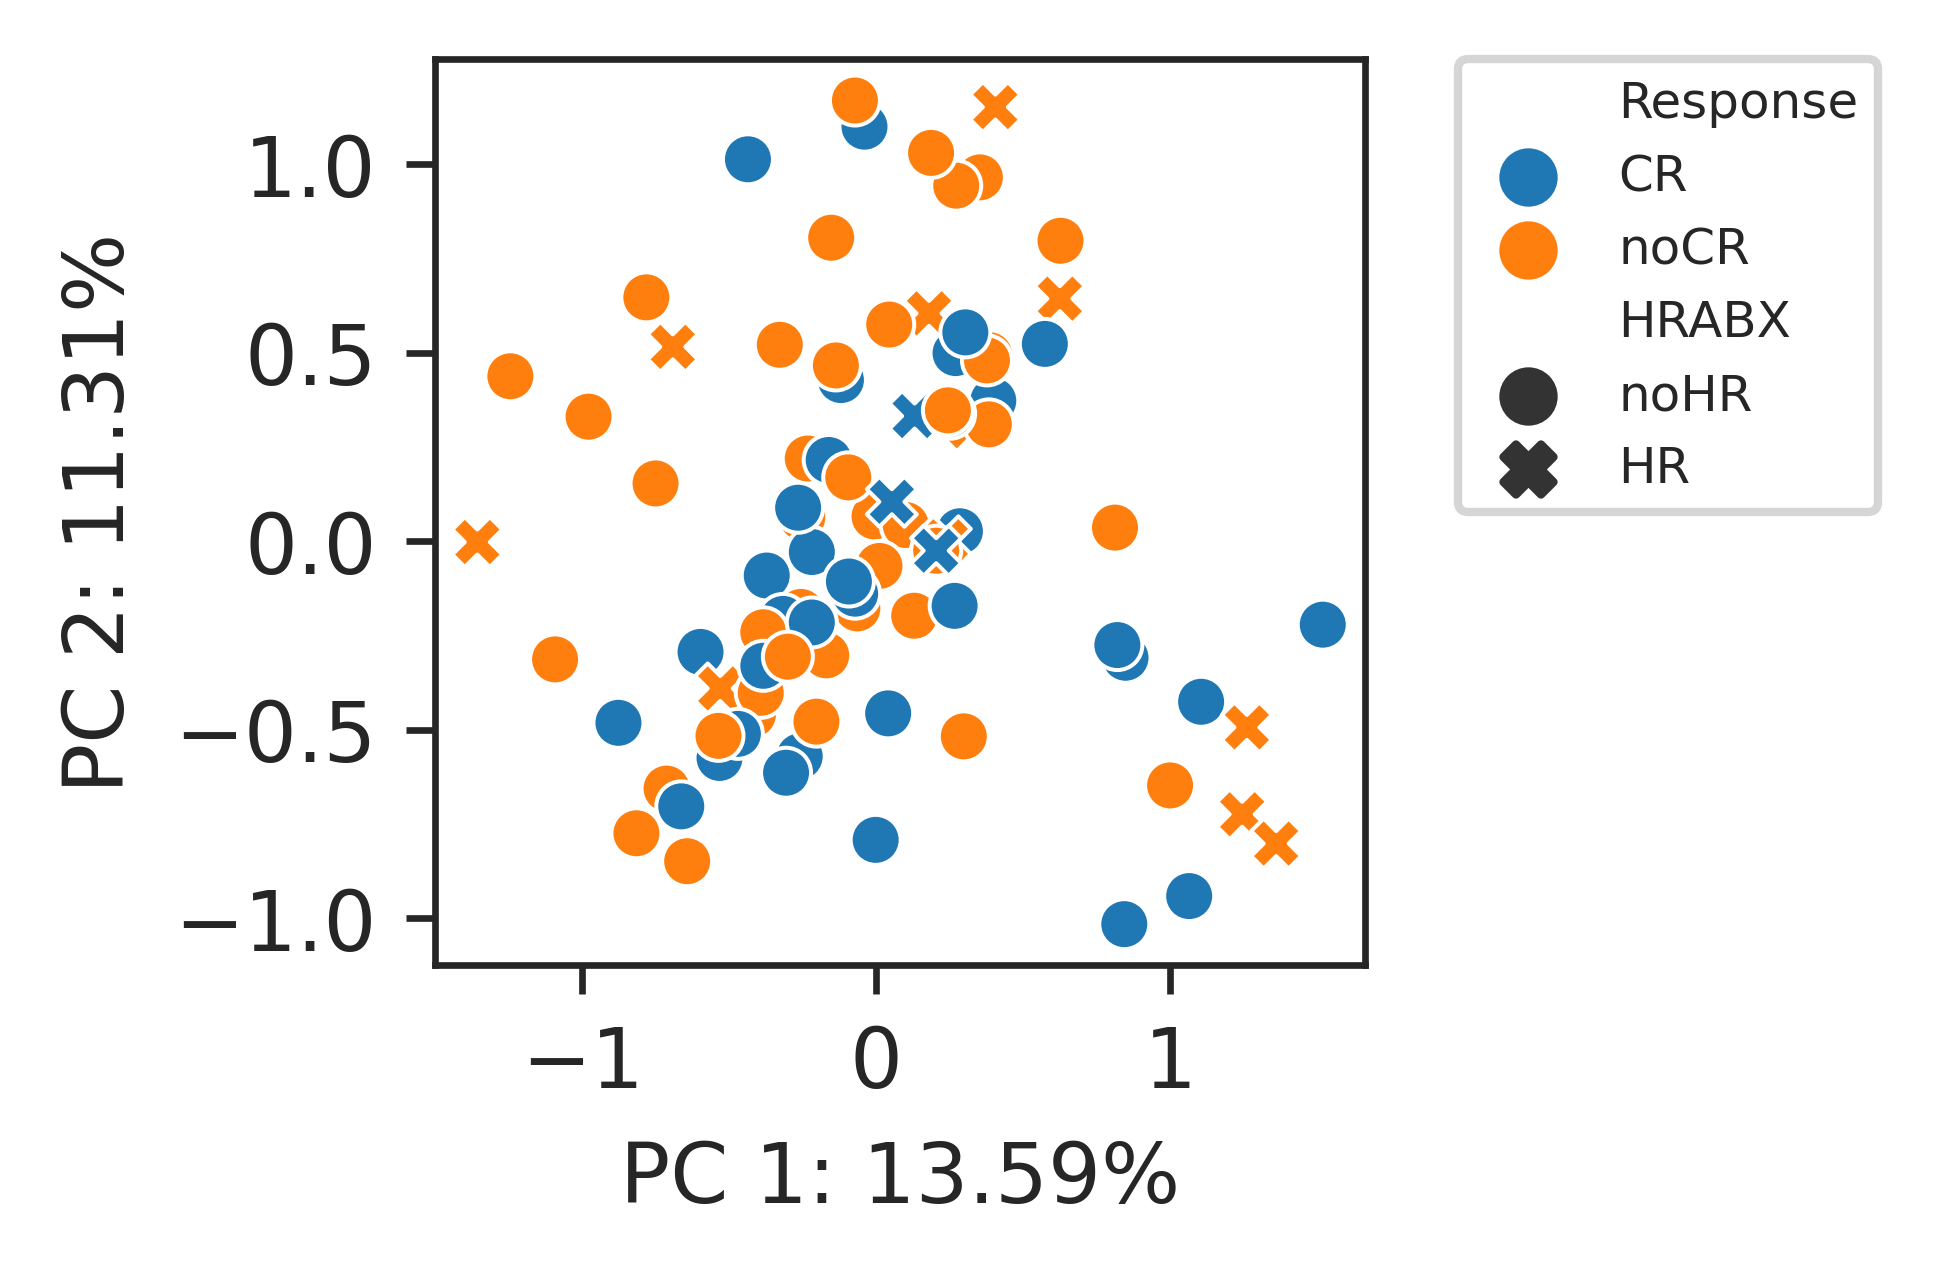

In [223]:


X_all_crhr =  prep_taxa_hr.transform(X_all_habx) 



pca_crhr = PCA()
pca_crhr_df = pd.DataFrame(pca_crhr.fit_transform(X_all_crhr), index = X_all_habx.index)
pca_crhr_df_columns = [f"PC {c+1}: {np.round(pca_crhr.explained_variance_ratio_[c]*100,2)}%" for c in pca_crhr_df.columns]
pca_crhr_df.columns = pca_crhr_df_columns
pca_crhr_df_response = pca_crhr_df.join(cr_y_habx.map({0:'noCR', 1:'CR'}))\
            .join(stool_table_habx.loc[:,['subjectID','Basal_no_HighRisk_sample']]\
                      .drop_duplicates().set_index('subjectID')\
                      .assign(HRABX = lambda df: df['Basal_no_HighRisk_sample'].map({True:"noHR",False:'HR'})))


fig, ax = plt.subplots(figsize = [2,2], dpi = 600)
sns.scatterplot(data = pca_crhr_df_response, x = pca_crhr_df_columns[0],y=pca_crhr_df_columns[1], hue='Response', style = 'HRABX')
plt.legend(fontsize = 6, loc = [1.1, .5])
plt.savefig("./deterministic_results/pca_crhr_df_response.pdf", bbox_inches='tight')

pca_crhr_df_response.to_csv("./deterministic_results/pca_crhr_df_response.csv")

